In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.6
  [780c37f4] Carlo v0.2.5
  [a93c6f00] DataFrames v1.8.0
  [f67ccb44] HDF5 v0.17.2
  [033835bb] JLD2 v0.6.2
  [ebeed567] PeriodicArrays v0.1.0 `https://github.com/PatXue/PeriodicArrays.jl#main`
  [90137ffa] StaticArrays v1.9.15


In [2]:
using CairoMakie
using Carlo.ResultTools
using DataFrames
using HDF5
using JLD2
using LinearAlgebra
using PeriodicArrays
using StaticArrays

In [11]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:init_type, :T, :Lx, :Ly, :Mag, :Energy, :ηz, :ηxy]
)

cleandata (generic function with 1 method)

In [4]:
function generatePlot(data::AbstractDataFrame, x, y;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return ax
end

function generatePlot(data::AbstractDataFrame, x, ys::Vector;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for (label, y) in zip(ys, eachcol(data[:, ys]))
        vals = getfield.(y, :val)
        errs = getfield.(y, :err)
        scatter!(data[:, x], vals; label="$label")
        if line
            lines!(data[:, x], vals)
        end
        errorbars!(data[:, x], vals, errs)
    end
    axislegend()

    return ax
end

function generatePlot(data::GroupedDataFrame, x, y;
                      title, xlabel, ylabel, line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return ax
end

generatePlot (generic function with 3 methods)

In [12]:
jobname = "afm-fe"
data = cleandata("../jobs/" * jobname * ".results.json")

Row,init_type,T,Lx,Ly,Mag,Energy,ηz,ηxy
,String,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…
1,const,0.5,20,20,0.02647±0.00014,-19.107±0.028,0.00032±0.00045,0.05802±0.0008
2,const,1.0,20,20,0.02645±0.00013,-18.816±0.026,-0.00042±0.0004,0.0594±0.0011
3,const,1.5,20,20,0.02672±0.00015,-18.41±0.024,-0.00054±0.00032,0.05707±0.00092
4,const,2.0,20,20,0.02706±0.00014,-18.061±0.016,-4.0e-5±0.00056,0.05689±0.00089
5,const,2.5,20,20,0.02747±0.00011,-17.693±0.022,-0.00011±0.00049,0.05398±0.00066
6,const,3.0,20,20,0.02767±0.00011,-17.32±0.02,-0.00044±0.00036,0.05362±0.00063
7,const,3.5,20,20,0.02772±0.00014,-16.982±0.021,-0.00015±0.00043,0.05437±0.00078
8,const,4.0,20,20,0.027934±7.5e-5,-16.621±0.021,0.00051±0.00036,0.05178±0.00049
9,const,4.5,20,20,0.02828±0.00013,-16.312±0.018,0.00018±0.00044,0.05158±0.00054


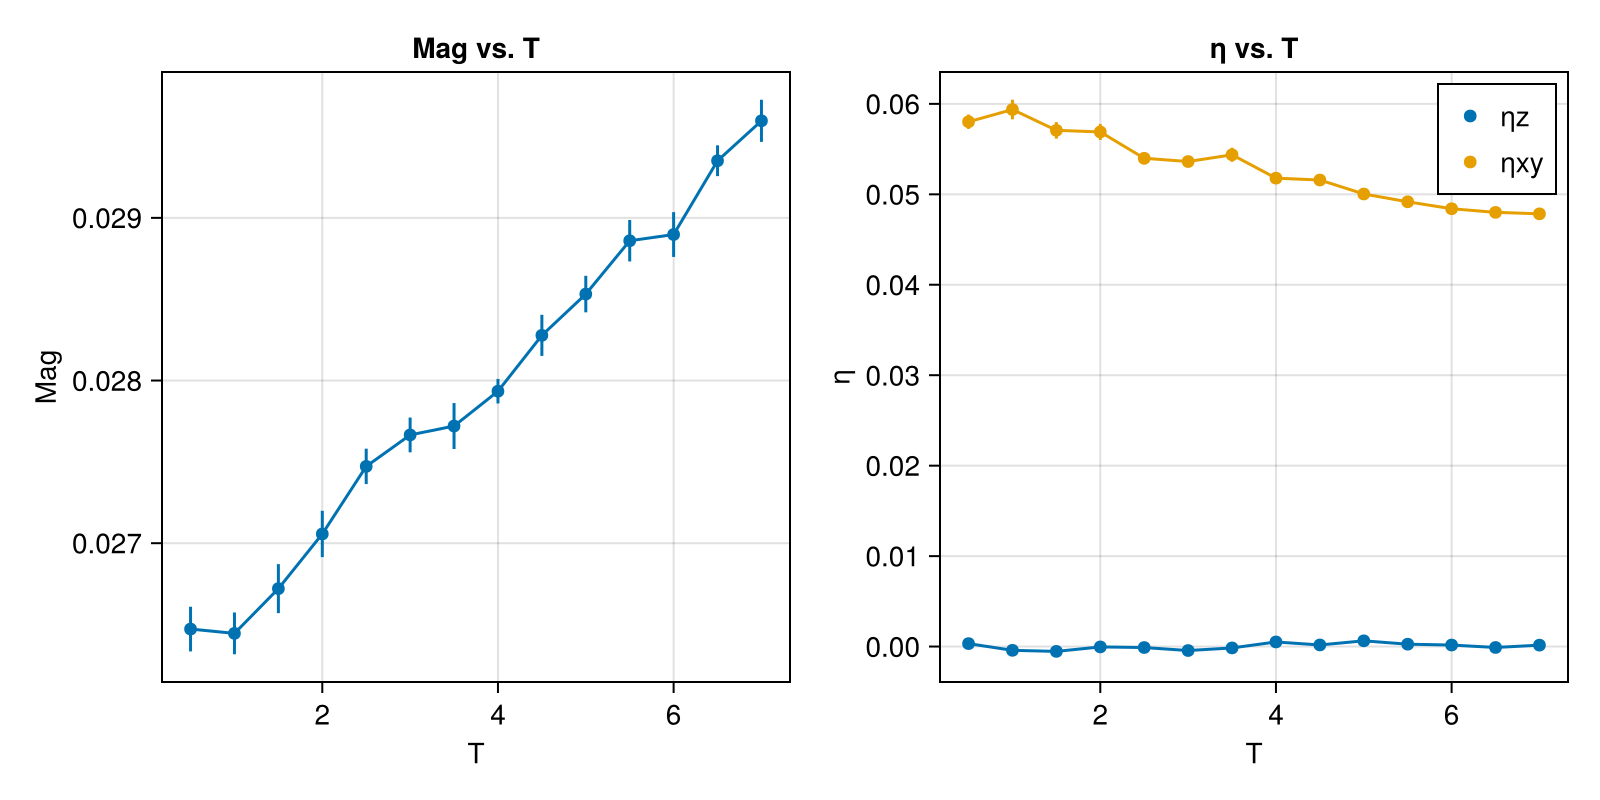

In [6]:
fig = Figure(size=(800, 400))
fig[1,1] = generatePlot(data, :T, :Mag; title="Mag vs. T", xlabel="T", ylabel="Mag", line=true)
fig[1,2] = generatePlot(data, :T, [:ηz, :ηxy]; title="η vs. T", xlabel="T", ylabel="η", line=true)
fig

In [7]:
function generate_mctime_plot(task_no::Int, fig=Figure(size=(800, 400)), fig_pos=(1, 1))
    ax_P = fig[fig_pos...] = Axis(
        fig,
        title="Magnetization vs. Bin #",
        xlabel="Bin #",
        ylabel="Magnetization",
        xminorticksvisible=true
    )

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.meas.h5") do file
        observables = file["observables"]

        mag_samples = read(observables, "Mag/samples")
        n = length(mag_samples)
        init = 1
        lines!(
            ax_P,
            collect(1:n),
            mag_samples[1:n],
        )
    end

    return fig
end

generate_mctime_plot (generic function with 3 methods)

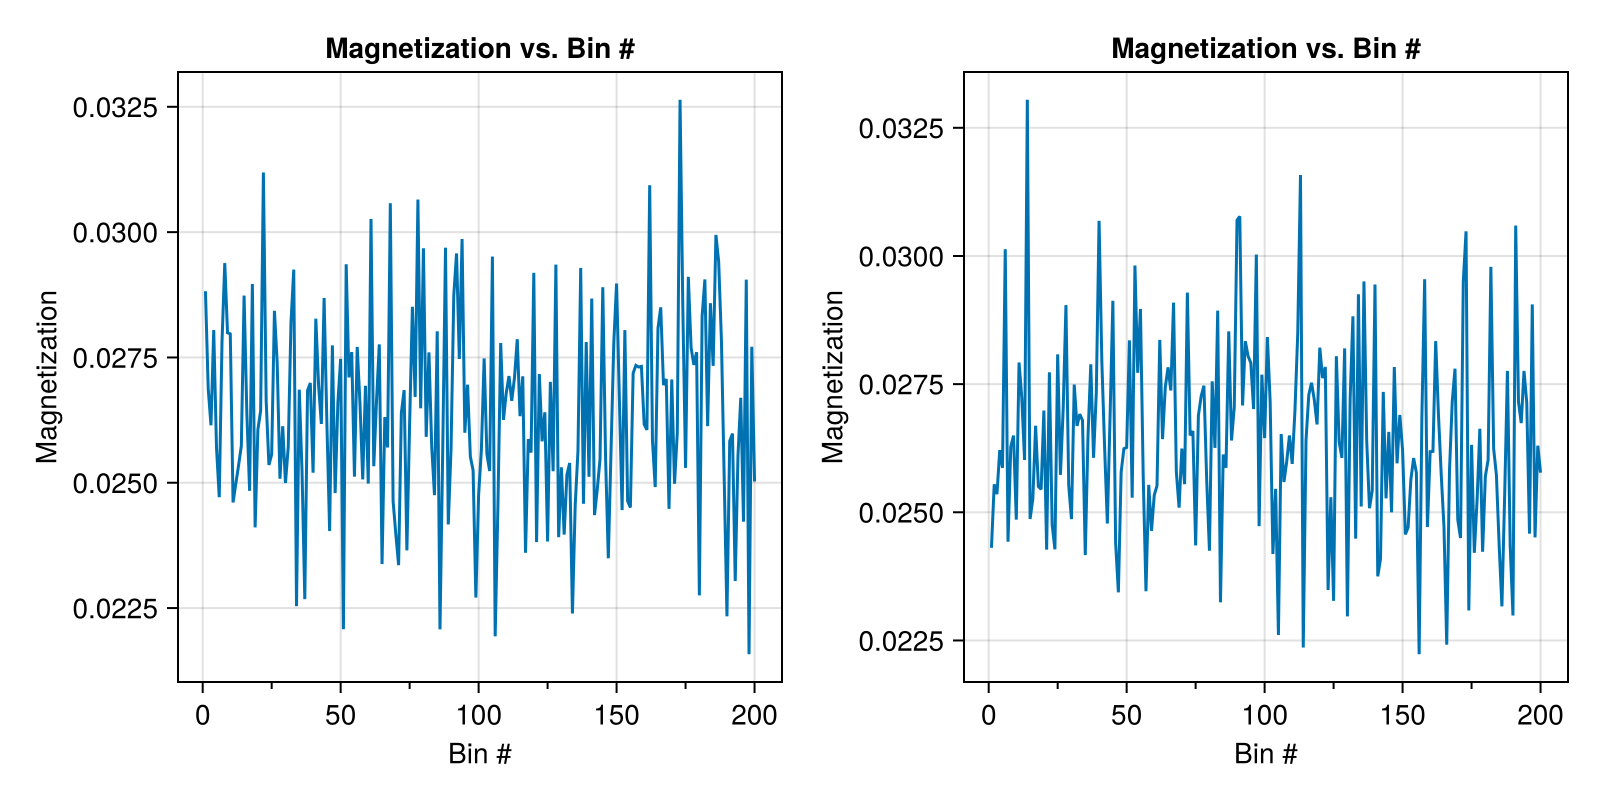

In [8]:
fig = Figure(size=(400, 800))
i = 1
fig = generate_mctime_plot(i)
generate_mctime_plot(i+1, fig, (1, 2))

In [9]:
function generate_spins(task_no::Int)
    fig = Figure(size=(800, 400))

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.dump.h5") do file
        spins = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/spins")
        )
        spin_xs = map(v -> v[1], spins)
        spin_ys = map(v -> v[2], spins)
        spin_zs = map(v -> v[3], spins)
        Lx, Ly = size(spins)
        fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")
        strength = vec(spin_zs)
        arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))

        ηs = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/etas")
        )
        η_xs = getindex.(ηs, 1)
        η_ys = getindex.(ηs, 2)
        η_zs = getindex.(ηs, 3)
        Lx, Ly = size(ηs)
        fig[1,2] = Axis(fig; title="ηs", backgroundcolor="black")
        strength = vec(η_zs)
        arrows2d!(1:Lx, 1:Ly, η_xs, η_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))
    end

    return fig
end

generate_spins (generic function with 1 method)

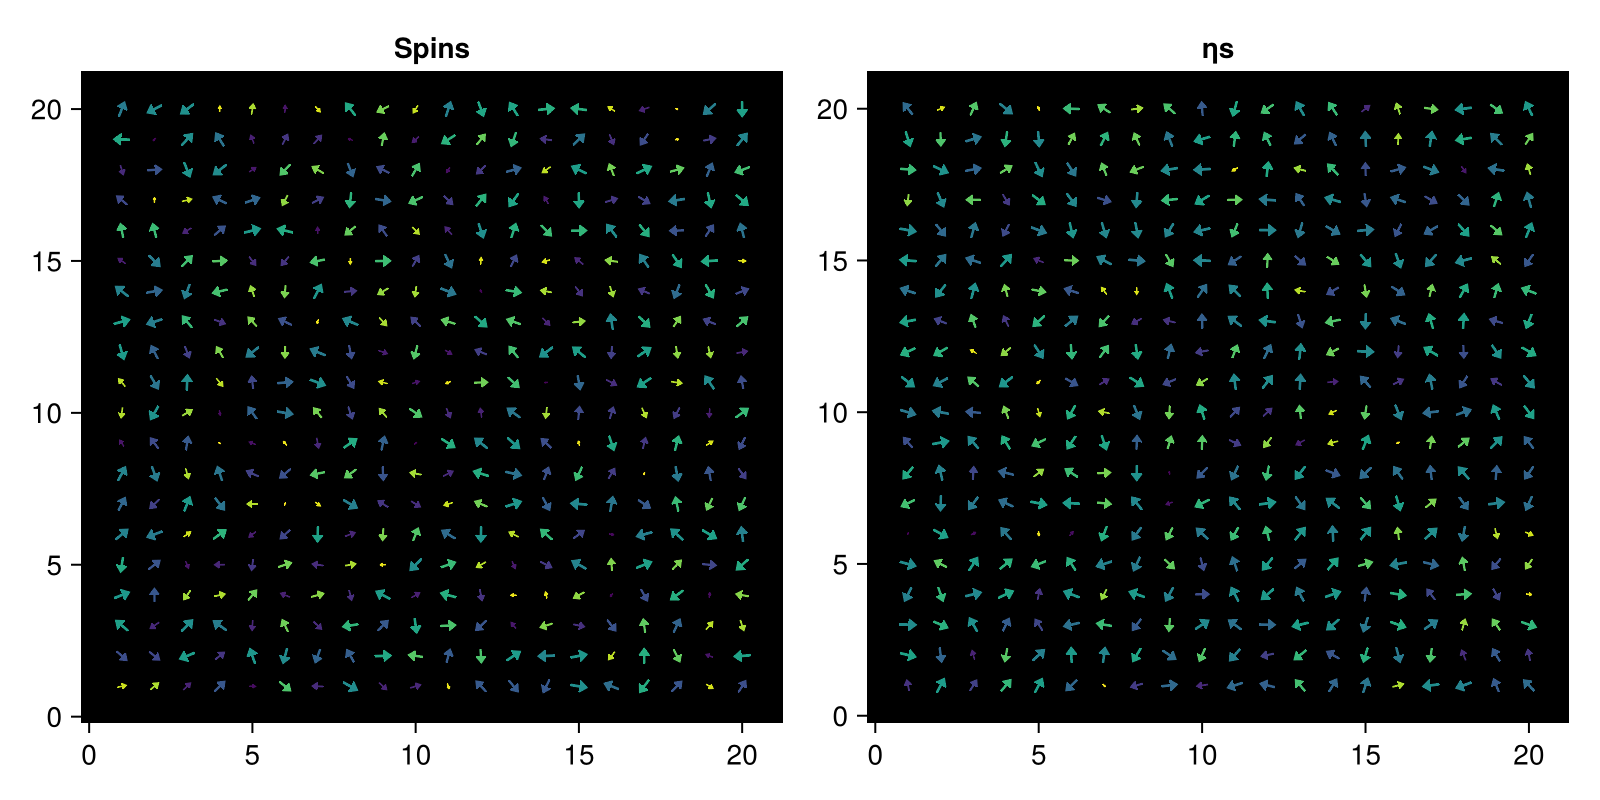

In [10]:
generate_spins(1)